# Initialization

In [24]:
install.packages("tidyverse")
install.packages("viridis")
library(tidyverse)
library(viridis)

SIM_DATA_FILEPATH = "containment_sims.csv"

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


## Utility functions

In [17]:
read.data = function(filepath) {
  data = read_csv(filepath)
  
  # add scenario, complexity, containment rotation
  scenario.split = with(data, strsplit(trialname, "_"))
  data$scenario = unlist(lapply(scenario.split, "[", 2))
  data$containment = unlist(lapply(scenario.split, "[", 4))
  data$complexity = unlist(lapply(scenario.split, "[", 6))
  data$rotation = unlist(lapply(scenario.split, "[", 7))
  data$rotation[is.na(data$rotation)] = "NONE" # avoid NAs in this column
  
  # convert trial sims to milliseconds, add log trial sims
  data$sim_time.ms = data$simulation_time * 1000
  data$log.sim_time.ms = log10(data$sim_time.ms)
  
  return(data)
}

get.simtime.se = function(data) {
  data %>%
  group_by(containment, complexity) %>%
  # in theory this could be column-name neutral but passing in the column name breaks everything...
  summarize(means = mean(sim_time.ms),
            trials = n(),
            se.lower = means - sqrt(var(sim_time.ms) / length(sim_time.ms)),
            se.upper = means + sqrt(var(sim_time.ms) / length(sim_time.ms))) %>%
  select(containment, complexity, means, trials, se.lower, se.upper)
}



# Graphing functions

In [18]:
CONTAINMENT_LABELS = c(
  l1 = "low containment",
  l2 = "medium containment",
  l3 = "high containment"
)

COMPLEXITY_LABELS = c(
  l1 = "none",
  l2 = "low",
  l3 = "medium",
  l4 = "high"
)

SCENARIO_LABELS = c(
  sc1 = "scenario 1",
  sc2 = "scenario 2",
  sc3 = "scenario 3",
  sc4 = "scenario 4"
)

CONTAINMENT_COMPLEXITY_LABELS = c(
  "l1-l1" = "low containment, no complexity",
  "l1-l2" = "low containment, low complexity",
  "l1-l3" = "low containment, medium complexity",
  "l1-l4" = "low containment, high complexity",
  "l2-l1" = "medium containment, no complexity",
  "l2-l2" = "medium containment, low complexity",
  "l2-l3" = "medium containment, medium complexity",
  "l2-l4" = "medium containment, high complexity",
  "l3-l1" = "high containment, no complexity",
  "l3-l2" = "high containment, low complexity",
  "l3-l3" = "high containment, medium complexity",
  "l3-l4" = "high containment, high complexity"
)

COMPLEXITY_CONTAINMENT_LABELS = c(
  "l1-l1" = "no complexity, low containment",
  "l1-l2" = "no complexity, medium containment",
  "l1-l3" = "no complexity, high containment",
  "l2-l1" = "low complexity, low containment",
  "l2-l2" = "low complexity, medium containment",
  "l2-l3" = "low complexity, high containment",
  "l3-l1" = "medium complexity, low containment",
  "l3-l2" = "medium complexity, medium containment",
  "l3-l3" = "medium complexity, high containment",
  "l4-l1" = "high complexity, low containment",
  "l4-l2" = "high complexity, medium containment",
  "l4-l3" = "high complexity, high containment"
)

COMPLEXITY_LABELS_VERBOSE = c(
  l1 = "no complexity",
  l2 = "low complexity",
  l3 = "medium complexity",
  l4 = "high complexity"
)

default.theme = theme(
  # titles
  plot.title = element_text(face = "bold", size = 32),
  axis.title.y = element_text(face = "bold", size = 36),
  axis.title.x = element_text(face = "bold", size = 36),
  # axis text
  axis.text.x = element_text(size = 24),
  axis.text.y = element_text(size = 20),
  # facet text
  strip.text = element_text(face = "bold", size = 28),
  # backgrounds, lines
  panel.background = element_blank(),
  strip.background = element_blank(),
  panel.grid = element_blank(),
  axis.line = element_line(color = "black"),
  legend.key = element_rect(colour = "transparent", fill = "transparent")
)


termination.theme = theme(
  # titles
  axis.title.y = element_text(face = "bold", size = 24),
  axis.title.x = element_text(face = "bold", size = 24),
  # axis text
  axis.text.x = element_text(size = 18),
  axis.text.y = element_text(size = 18),
  # facet text
  strip.text = element_text(face = "bold", size = 18),
  legend.text = element_text(size = 14),
  # backgrounds, lines
  panel.background = element_blank(),
  strip.background = element_blank(),
  panel.grid = element_blank(),
  axis.line = element_line(color = "black"),
  legend.key = element_rect(colour = "transparent", fill = "transparent"),
  legend.position = "bottom"
)


containment.complexity.plot = function(mean.data, title = "", xlab = "", ylab = "") {
  mean.data %>%
    ggplot(aes(x = complexity, y = means)) +
    geom_point(size = 5) +
    geom_errorbar(aes(ymin = se.lower, ymax = se.upper), width = 0.25) +
    scale_x_discrete(labels = COMPLEXITY_LABELS) +
    facet_wrap(. ~ containment,
               # scales = "free",
               labeller = labeller(containment = CONTAINMENT_LABELS)) +
    labs(x = xlab, y = ylab) +
    ggtitle(title) +
    default.theme
}

# Termination Analysis

In [20]:
term_data = read.data(SIM_DATA_FILEPATH)

term_summary = data.frame(containment = character(),
                          complexity = character(),
                          containment_complexity = character(),
                          complexity_containment = character(),
                          threshold = numeric(),
                          ntrials = numeric(),
                          termination_trials = numeric(),
                          termination_percent = numeric())

for (threshold in seq(1:60)) {
  term_summary = rbind(term_summary,
                       term_data %>%
                         group_by(containment, complexity) %>%
                         summarize(
                           containment_complexity = paste(unique(containment), unique(complexity), sep = "-"),
                           complexity_containment = paste(unique(complexity), unique(containment), sep = "-"),
                           threshold = threshold,
                           ntrials = n(),
                           termination_trials = sum(simulation_time <= threshold),
                           termination_percent = termination_trials / ntrials) %>%
                         as.data.frame()
  )
}


Parsed with column specification:
cols(
  trialname = col_character(),
  simulation_number = col_double(),
  max_simulation_time = col_double(),
  outcome = col_character(),
  endpoint_x = col_double(),
  endpoint_y = col_double(),
  bounces = col_double(),
  simulation_time = col_double()
)


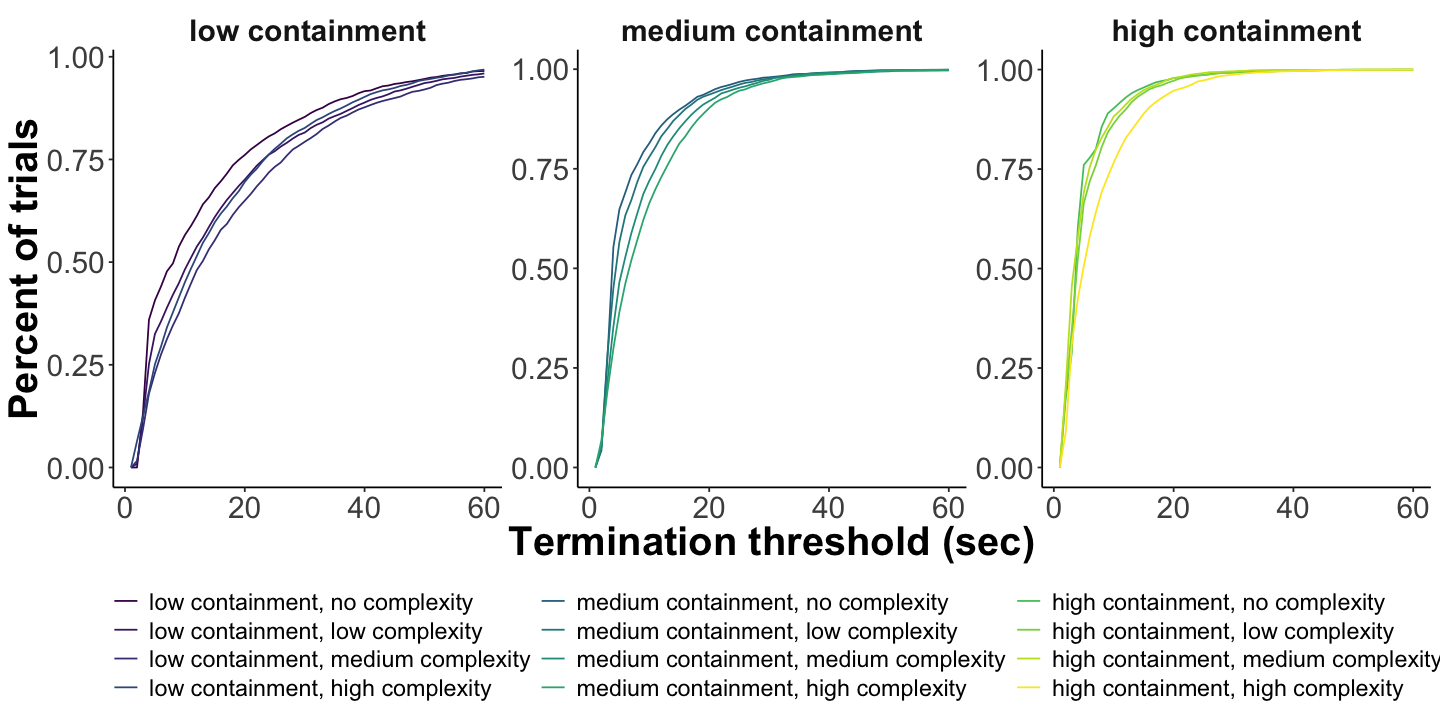

In [30]:
# Plot termination thresholds by containment level
options(repr.plot.width = 12, repr.plot.height = 6)
term_summary %>%
  ggplot(aes(x = threshold, y = termination_percent, color = containment_complexity)) +
  geom_line() +
  scale_color_viridis(discrete = T,
                      name = element_blank(),
                      labels = CONTAINMENT_COMPLEXITY_LABELS) +
  labs(x = "Termination threshold (sec)", y = "Percent of trials") +
  facet_wrap(. ~ containment,
             scales = "free",
             labeller = labeller(containment = CONTAINMENT_LABELS)) +
  guides(color = guide_legend(ncol = 3)) +
  termination.theme


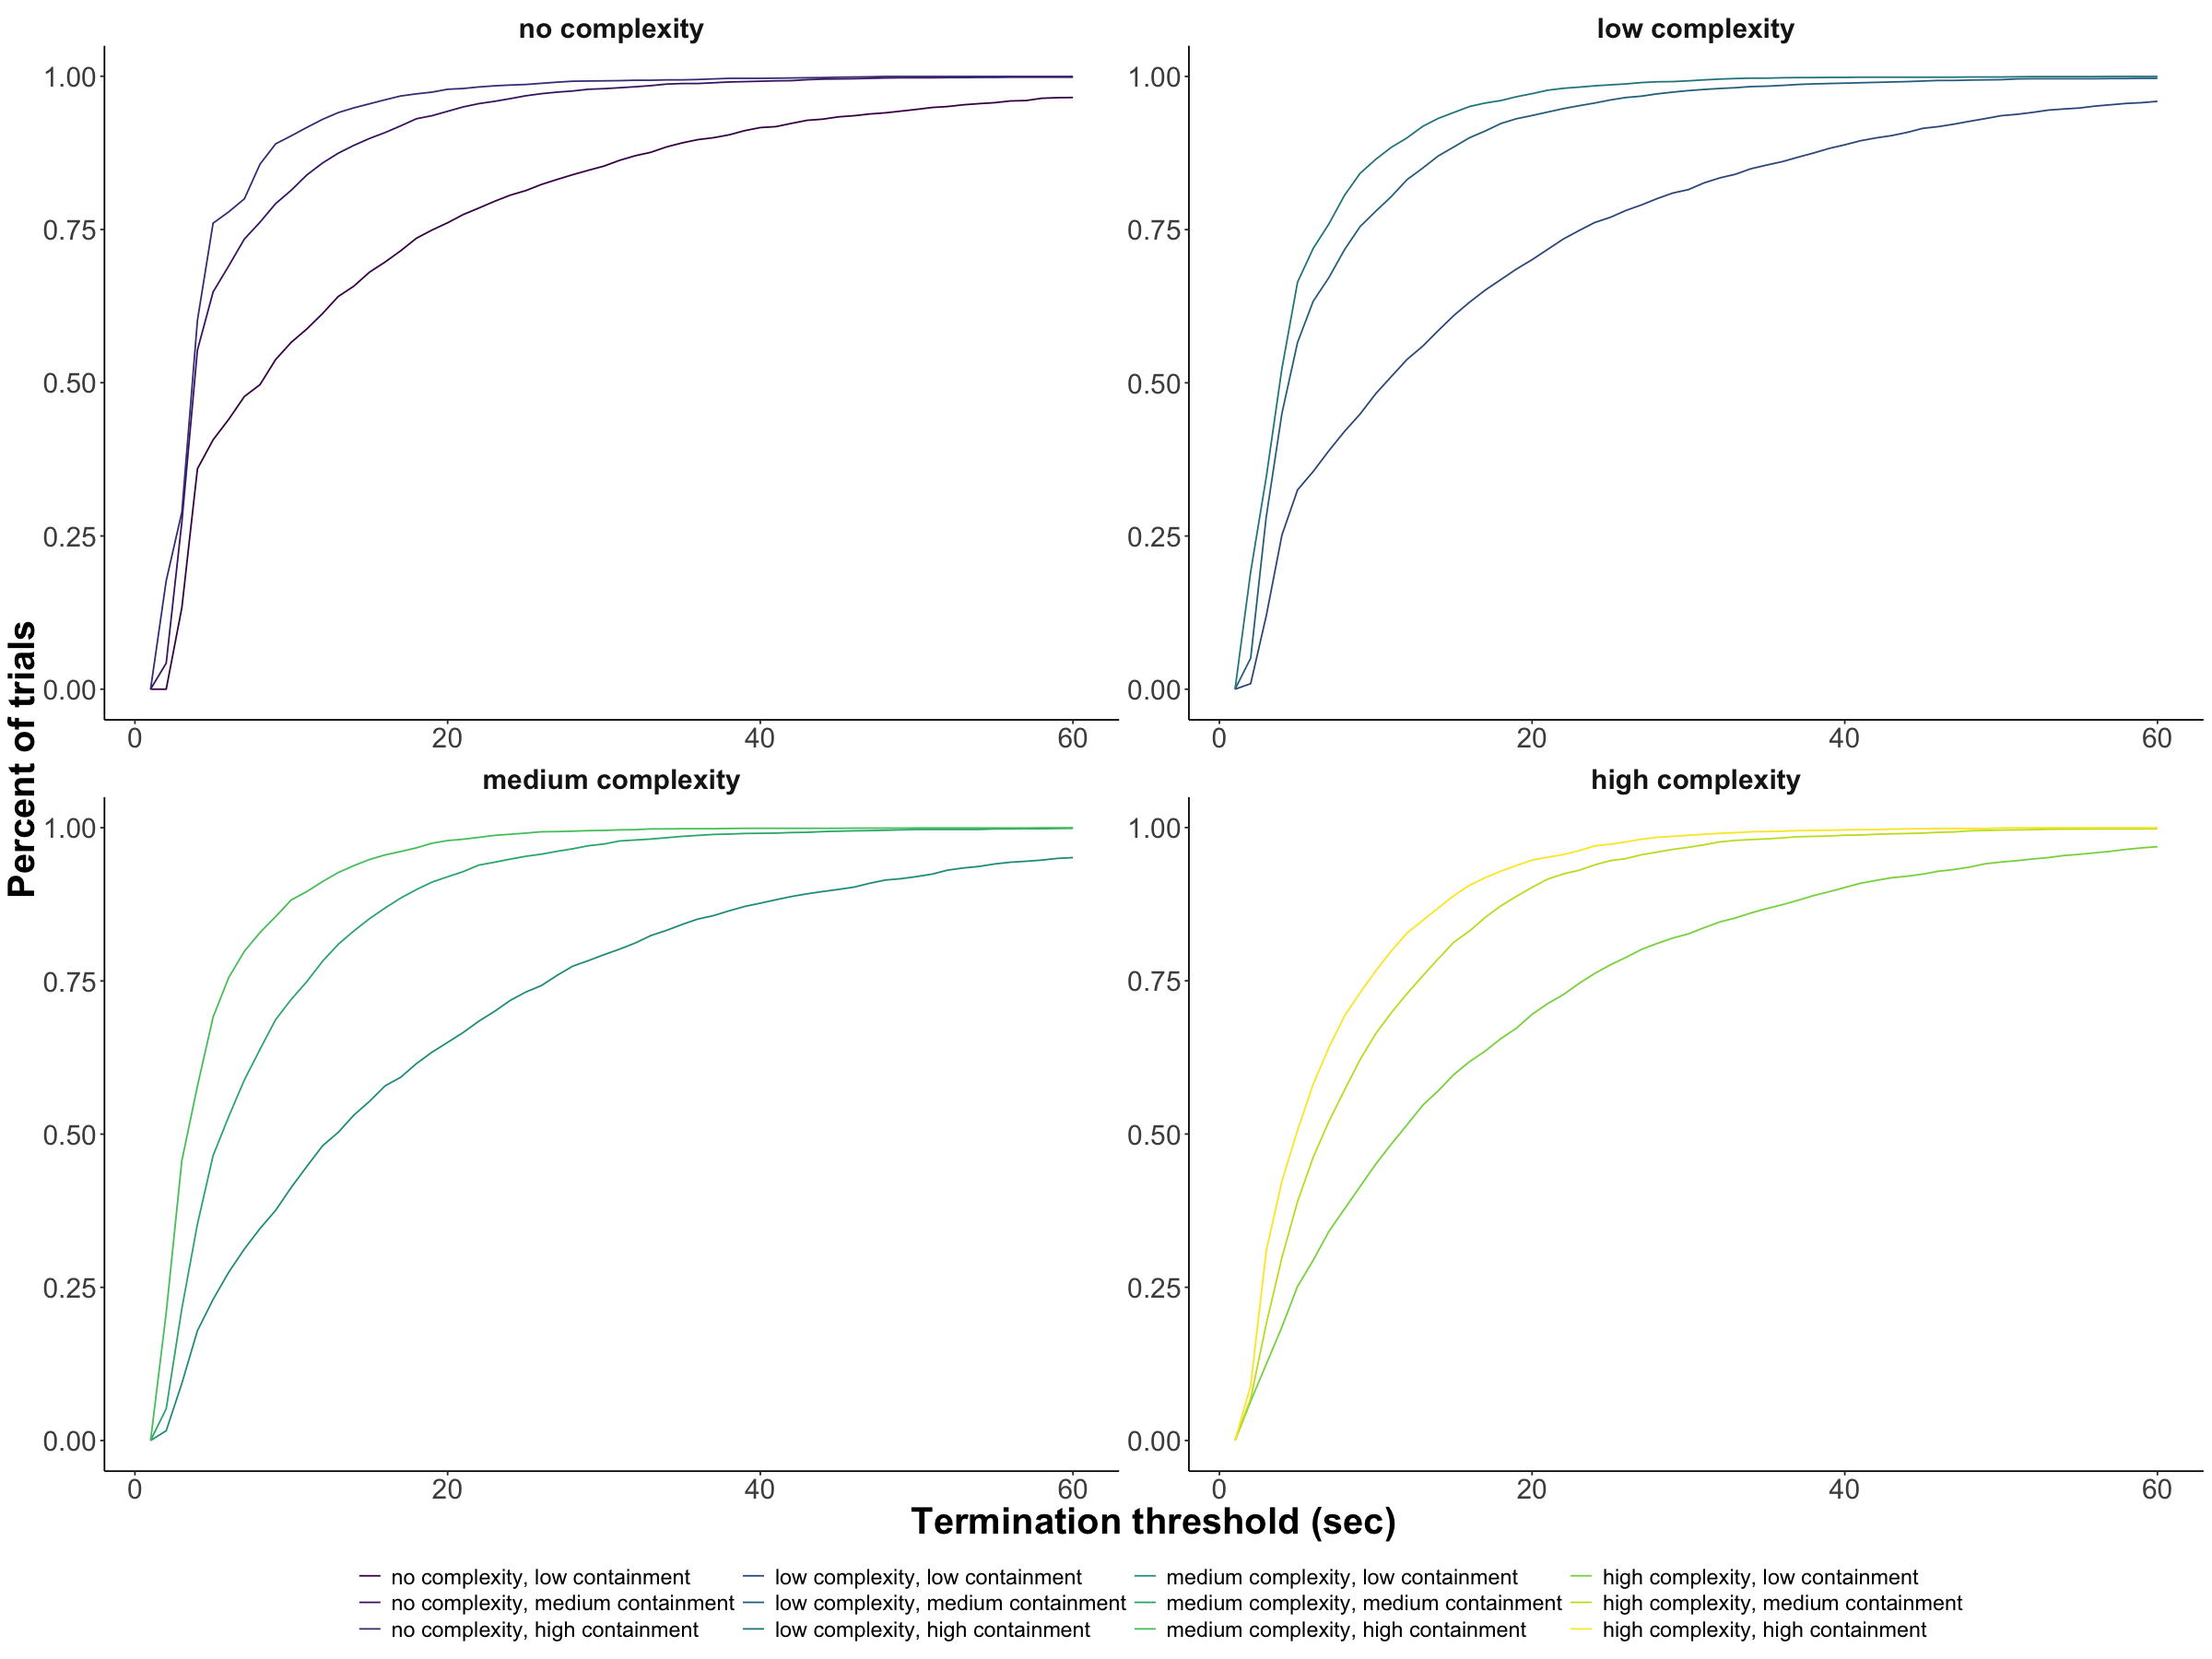

In [36]:
options(repr.plot.width = 20, repr.plot.height = 15)
# Plot termination threshold by complexity level
term_summary %>%
  ggplot(aes(x = threshold, y = termination_percent, color = complexity_containment)) +
  geom_line() +
  scale_color_viridis(discrete = T,
                      name = element_blank(),
                      labels = COMPLEXITY_CONTAINMENT_LABELS) +
  labs(x = "Termination threshold (sec)", y = "Percent of trials") +
  facet_wrap(. ~ complexity,
             scales = "free",
             labeller = labeller(complexity = COMPLEXITY_LABELS_VERBOSE)) +
  guides(color = guide_legend(ncol = 4)) +
  termination.theme


# Simulation Time Analysis

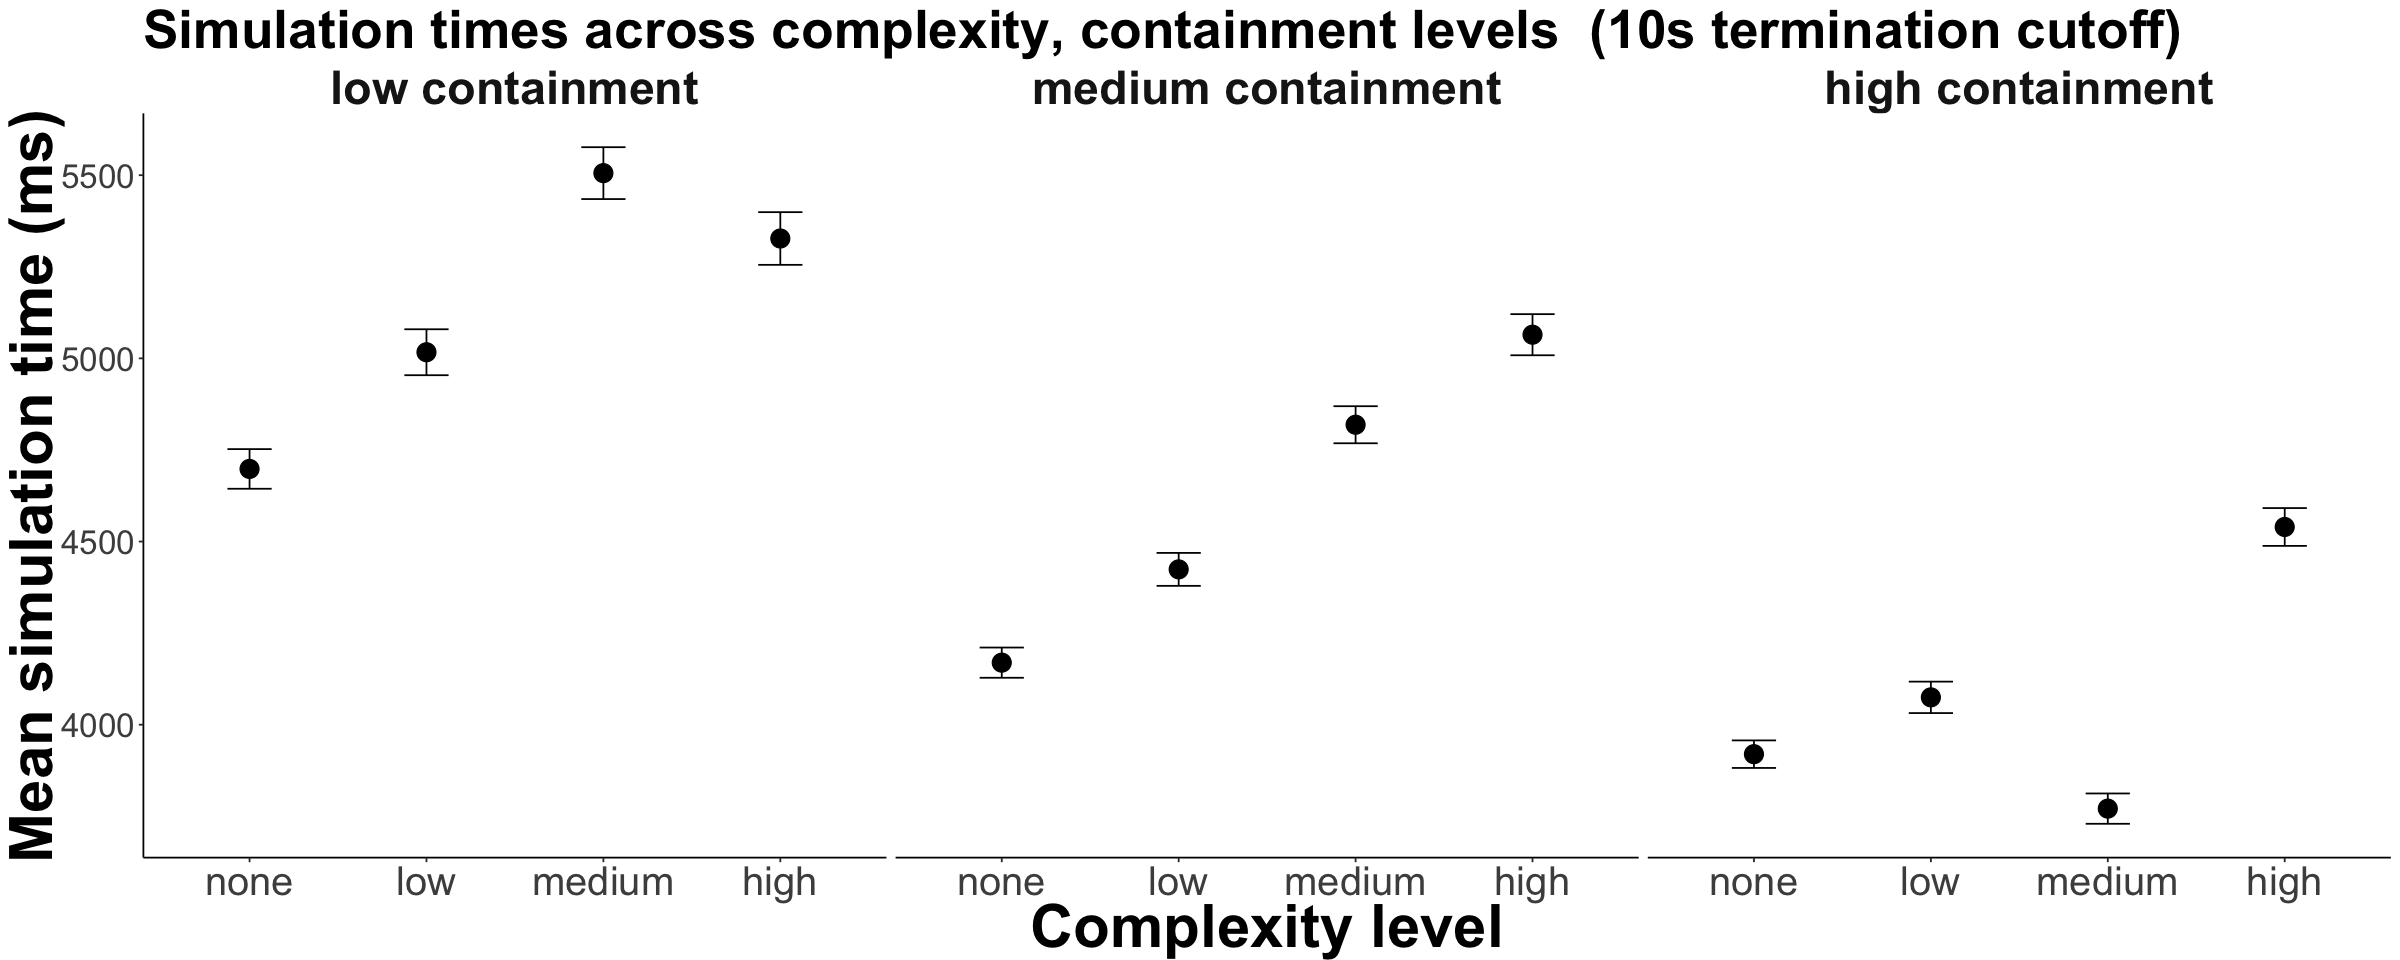

In [43]:
simtime_summary = data.frame(containment = character(), 
                             complexity = character(),
                             threshold = numeric(),
                             means = numeric(), 
                             trials = numeric(), 
                             se.lower = numeric(), 
                             se.upper = numeric())

for (threshold in seq(1, 61, by = 10)) {
  threshold_summary = term_data %>% 
    filter(simulation_time < threshold)
  summary_data = as.data.frame(get.simtime.se(threshold_summary))
  summary_data$threshold = threshold
  simtime_summary = rbind(simtime_summary,
                          summary_data)
}


options(repr.plot.width = 20, repr.plot.height = 8)
title = "Simulation times across complexity, containment levels"
xlab = "Complexity level"
ylab = "Mean simulation time (ms)"

simtime_summary %>%
  filter(threshold == 11) %>%
  containment.complexity.plot(paste(title, " (10s termination cutoff)"), xlab, ylab)


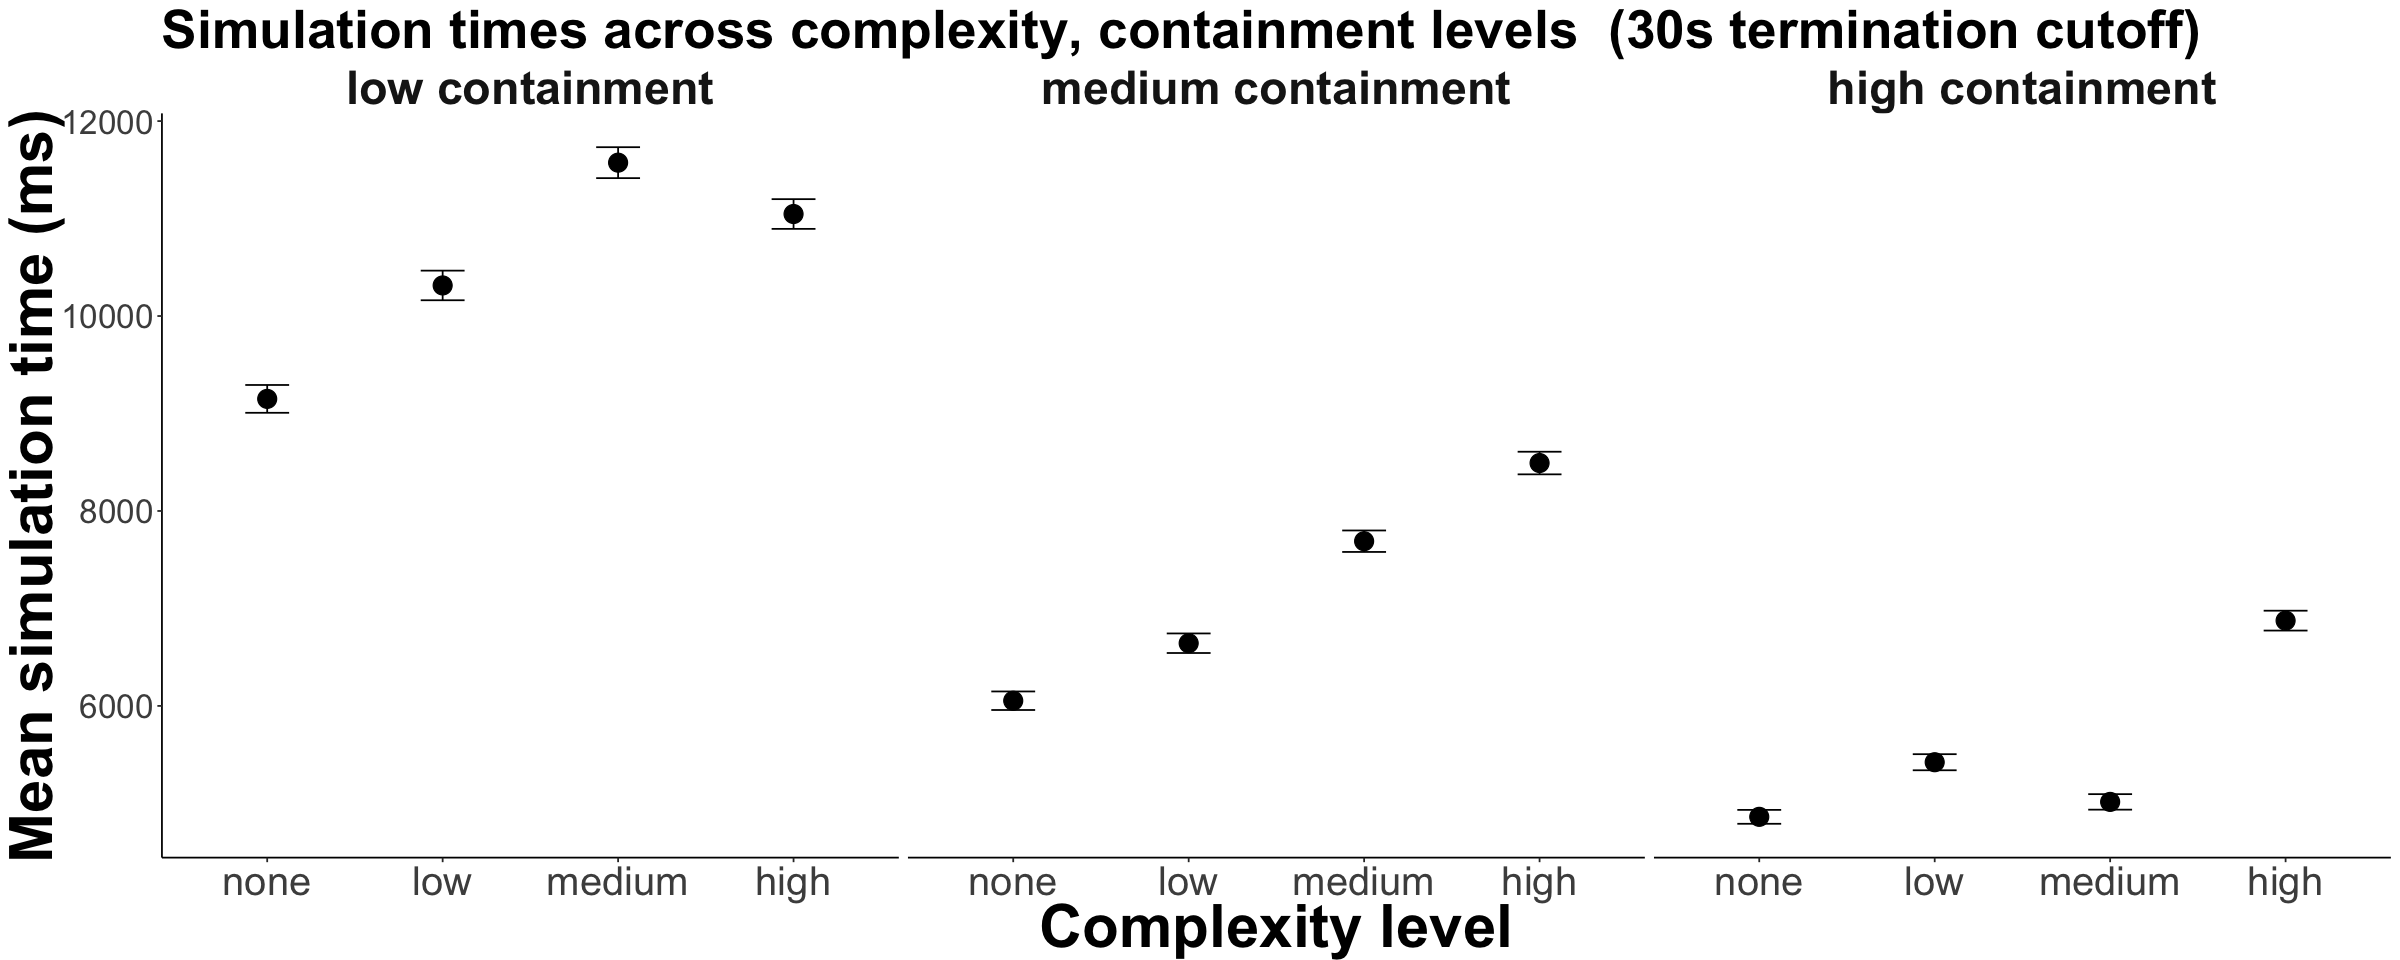

In [44]:
simtime_summary %>%
  filter(threshold == 31) %>%
  containment.complexity.plot(paste(title, " (30s termination cutoff)"), xlab, ylab)


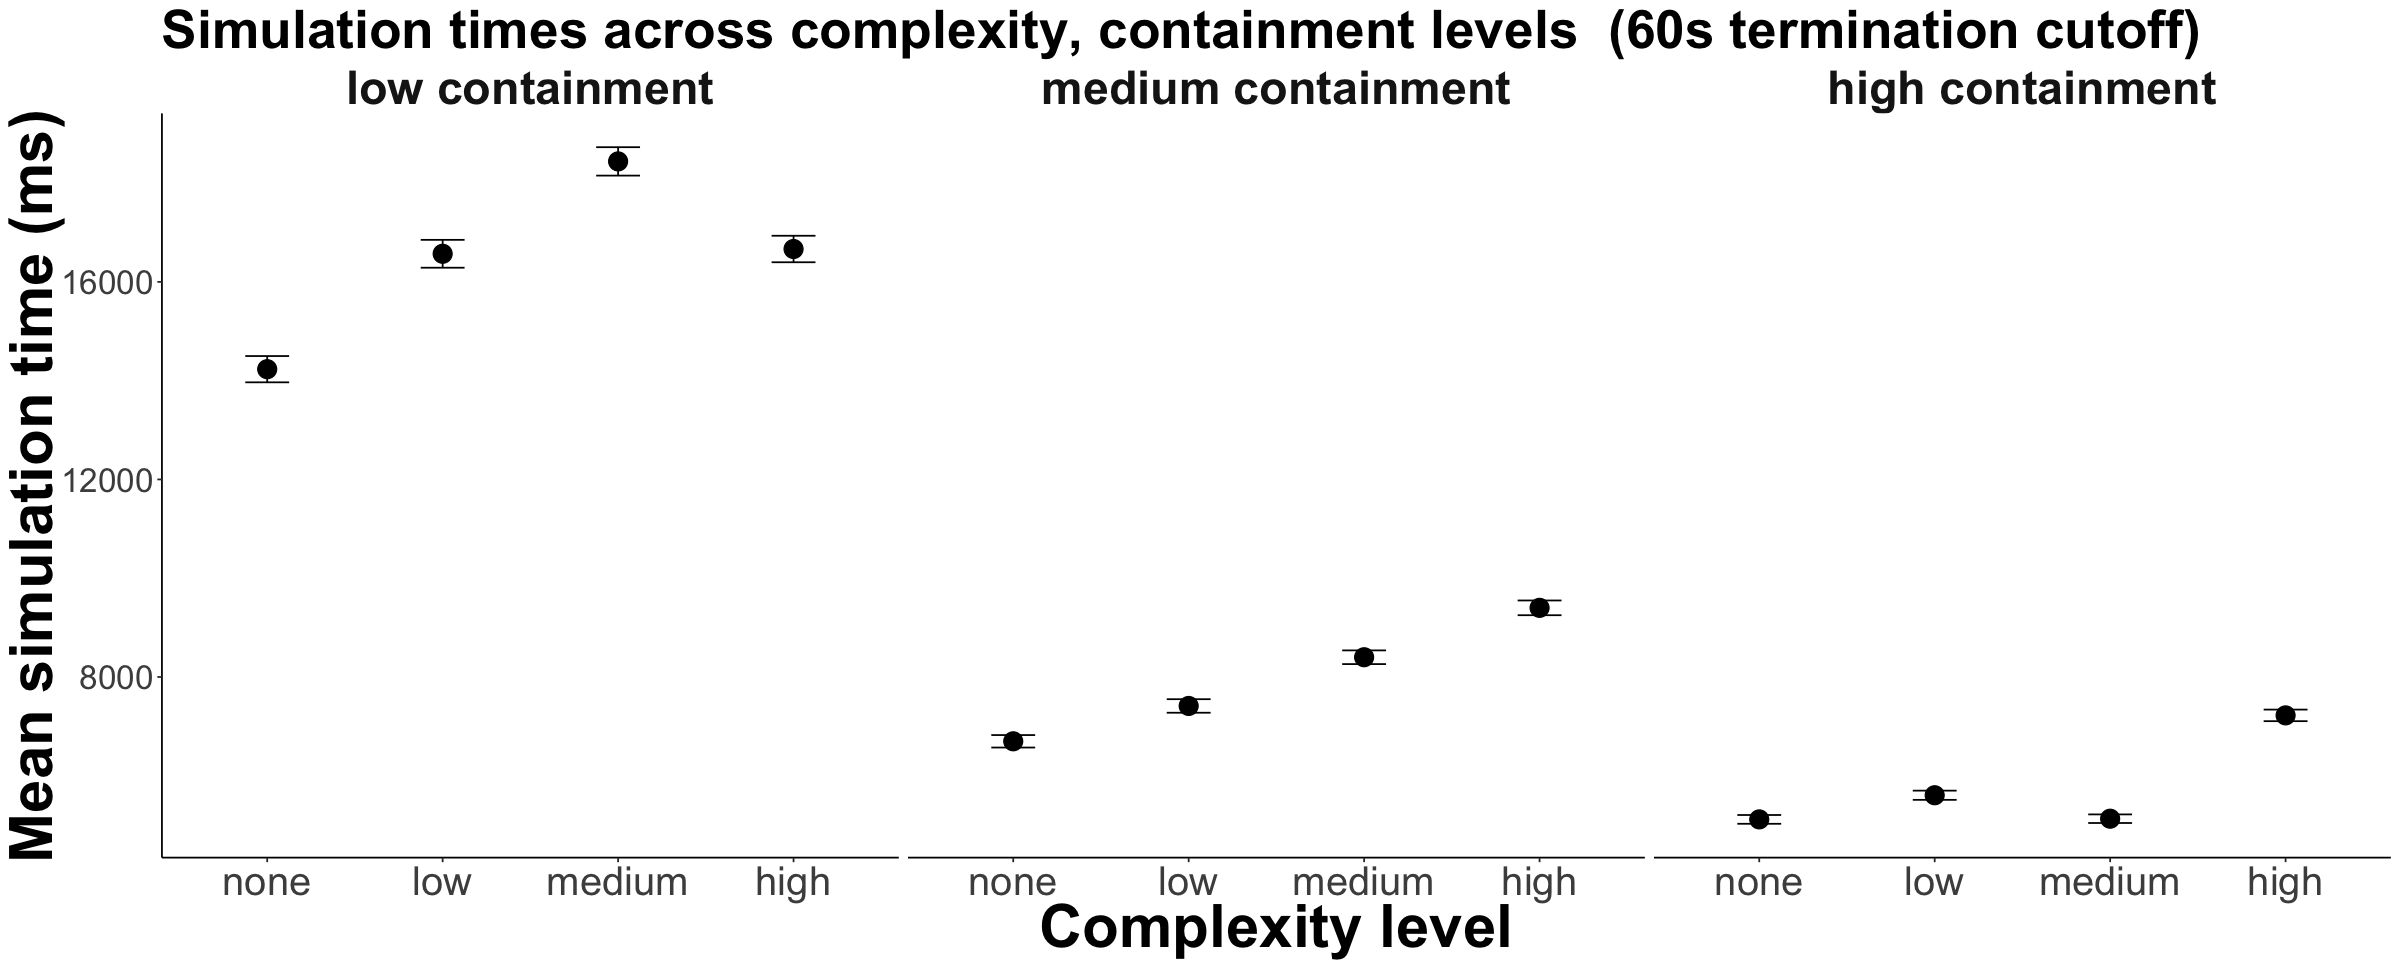

In [45]:
simtime_summary %>%
  filter(threshold == 61) %>%
  containment.complexity.plot(paste(title, " (60s termination cutoff)"), xlab, ylab)
